In [2]:
# ==============================
# Cell 1: Setup and imports
# ==============================
import sys
from pathlib import Path

# Ensure project root is in Python path
project_root = Path().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.insert(0, str(project_root))
print("Project root added to sys.path:", project_root)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure plotting and logging
sns.set(style="whitegrid")
%matplotlib inline
logging.basicConfig(level=logging.INFO)

# Custom modules
from src.data_processing.load_data import load_brent_data
from src.data_processing.preprocess import prepare_model_data
from src.modelling.bayesian_cp_model import run_bayesian_change_point_model
from src.modelling.analysis_utils import build_change_point_report, export_detected_event_csv


Project root added to sys.path: C:\Users\derej\Desktop\Kifya\changepoint_analysis


In [3]:
# File path
raw_file = project_root / "data" / "raw" / "BrentOilPrices.csv"

# Load data
df = load_brent_data(raw_file)
df.head()


C:\Users\derej\Desktop\Kifya\changepoint_analysis\src\data_processing\load_data.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)
INFO:src.data_processing.load_data:Loaded Brent dataset with 9011 rows


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
# ==============================
# Cell 3: Preprocess data for Bayesian modeling
# ==============================

# Prepare data for modeling
# aggregate='W' -> weekly aggregation to speed up Bayesian sampling
model_df = prepare_model_data(df, aggregate='W')

# Inspect first few rows
model_df.head()


INFO:src.data_processing.preprocess:Aggregated data using 'W' frequency. New shape: (1853, 2)
INFO:src.data_processing.preprocess:Computed log returns. Final modeling dataset shape: (1852, 3)


,Date,Price,LogReturn
0,1987-05-31,18.58,0.001616
1,1987-06-07,18.65,0.003760
2,1987-06-14,18.78,0.006946
3,1987-06-21,19.05,0.014275
4,1987-06-28,19.08,0.001574


INFO:src.data_processing.preprocess:Aggregated data using 'W' frequency. New shape: (1853, 2)
INFO:src.data_processing.preprocess:Computed log returns. Final modeling dataset shape: (1852, 3)


,Date,Price,LogReturn
0,1987-05-31,18.58,0.001616
1,1987-06-07,18.65,0.003760
2,1987-06-14,18.78,0.006946
3,1987-06-21,19.05,0.014275
4,1987-06-28,19.08,0.001574


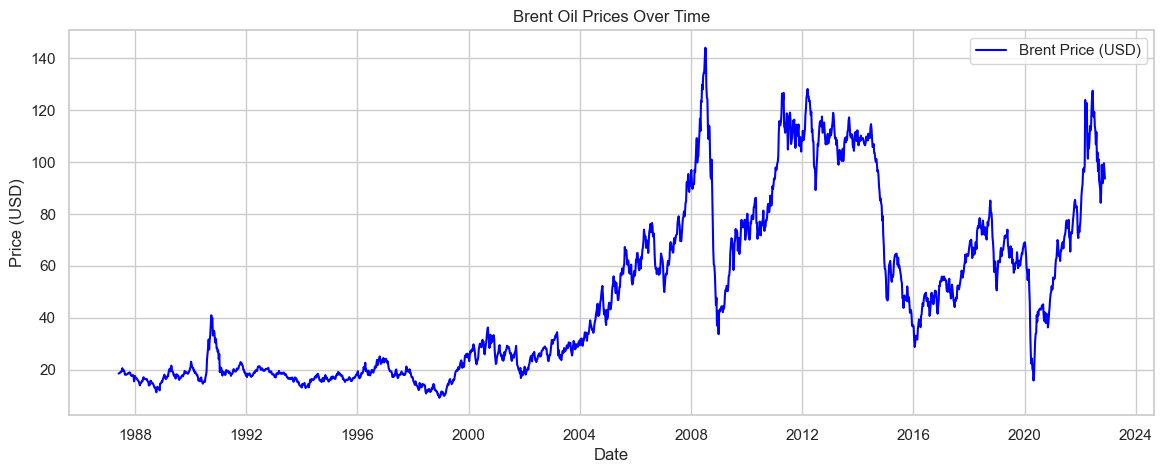

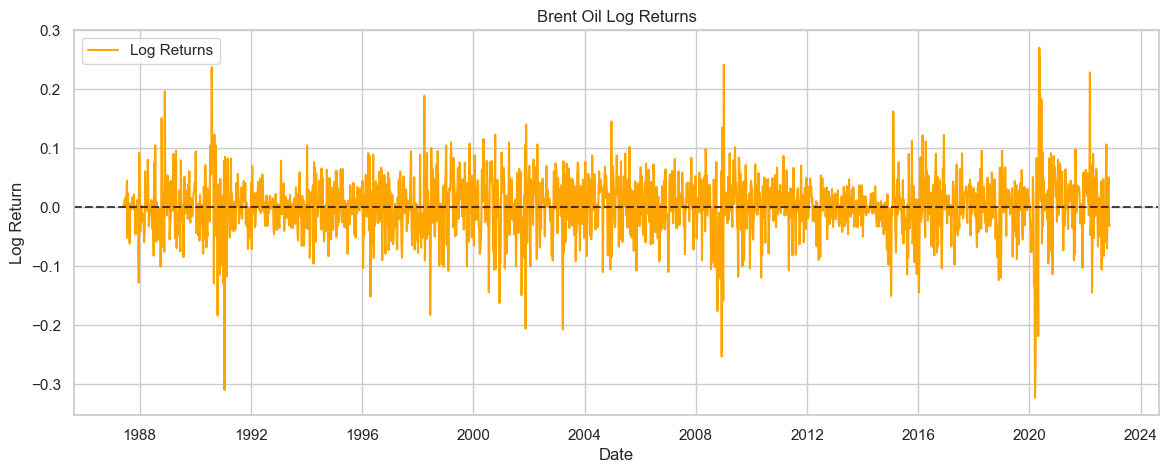

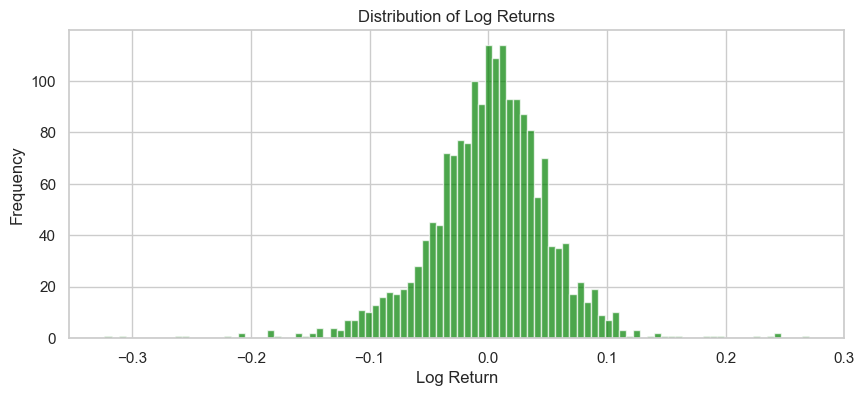

In [ ]:
# ==============================
# Cell 3: Preprocess data and visualize
# ==============================

# 1️ Prepare data for modeling (weekly aggregation to speed up MCMC)
model_df = prepare_model_data(df, aggregate='W')

# 2️ Inspect first few rows
display(model_df.head())

# 3️ Plot raw Brent Prices
plt.figure(figsize=(14, 5))
plt.plot(model_df['Date'], model_df['Price'], color='blue', label='Brent Price (USD)')
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# 4️ Plot log returns to see volatility clustering
plt.figure(figsize=(14, 5))
plt.plot(model_df['Date'], model_df['LogReturn'], color='orange', label='Log Returns')
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 5️ Optional: Histogram of log returns
plt.figure(figsize=(10, 4))
plt.hist(model_df['LogReturn'].dropna(), bins=100, color='green', alpha=0.7)
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()


Detected Change Point Date: 2020-03-01
Mean Log Return Before Change Point: 0.00067
Mean Log Return After Change Point: 0.00327
Overall Std Dev: 0.05151


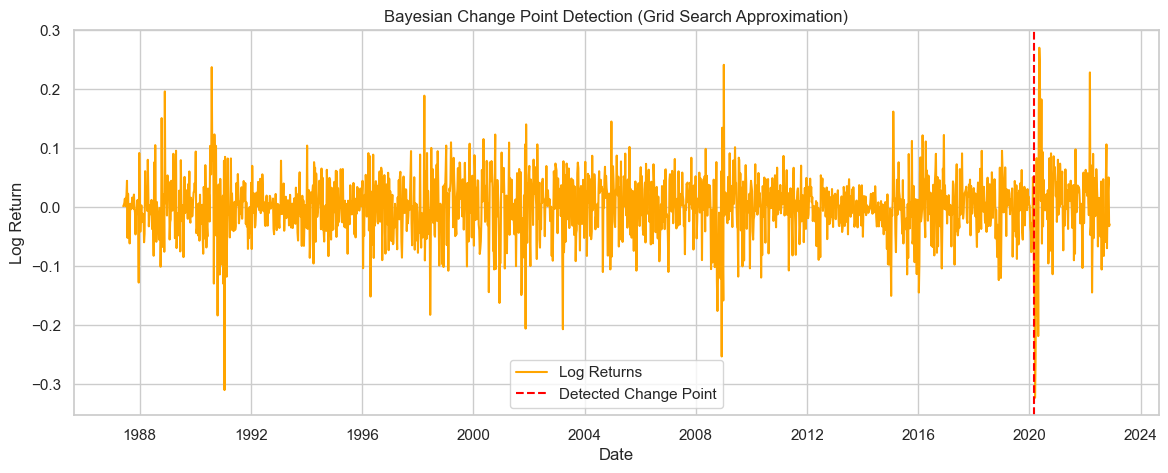

In [ ]:
# ==============================
# Cell 4: Fast Grid Search Change Point Detection
# ==============================

# 1️ Prepare log returns and align dates properly
log_returns = model_df['LogReturn']
mask = log_returns.notna()  # only valid log returns
y = log_returns[mask].reset_index(drop=True)
dates = model_df['Date'][mask].reset_index(drop=True)
n = len(y)

# 2️ Define log-likelihood for candidate tau
def log_likelihood(tau, y):
    """
    Simple Gaussian log-likelihood assuming different mean before/after tau
    """
    y_before = y[:tau]
    y_after = y[tau:]
    mu1, mu2 = y_before.mean(), y_after.mean()
    sigma1, sigma2 = y_before.std(ddof=1), y_after.std(ddof=1)
    ll_before = -0.5 * np.sum(((y_before - mu1)/sigma1)**2 + np.log(2*np.pi*sigma1**2))
    ll_after  = -0.5 * np.sum(((y_after - mu2)/sigma2)**2 + np.log(2*np.pi*sigma2**2))
    return ll_before + ll_after

# 3️ Grid search for tau (skip first and last 50 points to avoid edge effects)
tau_candidates = range(50, n-50)
ll_values = [log_likelihood(tau, y) for tau in tau_candidates]

# 4️ Pick tau with max log-likelihood
best_tau = tau_candidates[np.argmax(ll_values)]
change_point_date = dates.iloc[best_tau]
print(f"Detected Change Point Date: {change_point_date.date()}")

# 5️ Compute mean log returns before and after change point
y_before = y[:best_tau]
y_after = y[best_tau:]
mu1_mean, mu2_mean = y_before.mean(), y_after.mean()
sigma = y.std(ddof=1)
print(f"Mean Log Return Before Change Point: {mu1_mean:.5f}")
print(f"Mean Log Return After Change Point: {mu2_mean:.5f}")
print(f"Overall Std Dev: {sigma:.5f}")

# 6️ Plot log returns with detected change point
plt.figure(figsize=(14,5))
plt.plot(dates, y, label='Log Returns', color='orange')
plt.axvline(change_point_date, color='red', linestyle='--', label='Detected Change Point')
plt.title("Bayesian Change Point Detection (Grid Search Approximation)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()


Detected Change Point Date: 1987-08-04, Mean Before: 0.00226, Mean After: -0.00123, Std Dev: 0.01765
Detected Change Point Date: 1987-08-25, Mean Before: -0.01207, Mean After: -0.00059, Std Dev: 0.01865
Detected Change Point Date: 1988-03-03, Mean Before: -0.00178, Mean After: 0.00071, Std Dev: 0.01878
Detected Change Point Date: 1988-08-23, Mean Before: -0.00067, Mean After: -0.00919, Std Dev: 0.01824
Detected Change Point Date: 1988-10-06, Mean Before: -0.00144, Mean After: 0.00227, Std Dev: 0.01969
Detected Change Point Date: 1989-04-21, Mean Before: 0.00501, Mean After: 0.00021, Std Dev: 0.02100
Detected Change Point Date: 1990-01-08, Mean Before: 0.00032, Mean After: -0.00339, Std Dev: 0.01976
Detected Change Point Date: 1990-07-10, Mean Before: -0.00027, Mean After: 0.01755, Std Dev: 0.02227
Detected Change Point Date: 1990-09-28, Mean Before: 0.00093, Mean After: -0.00037, Std Dev: 0.02218
Detected Change Point Date: 1991-02-19, Mean Before: -0.00852, Mean After: 0.00011, Std De

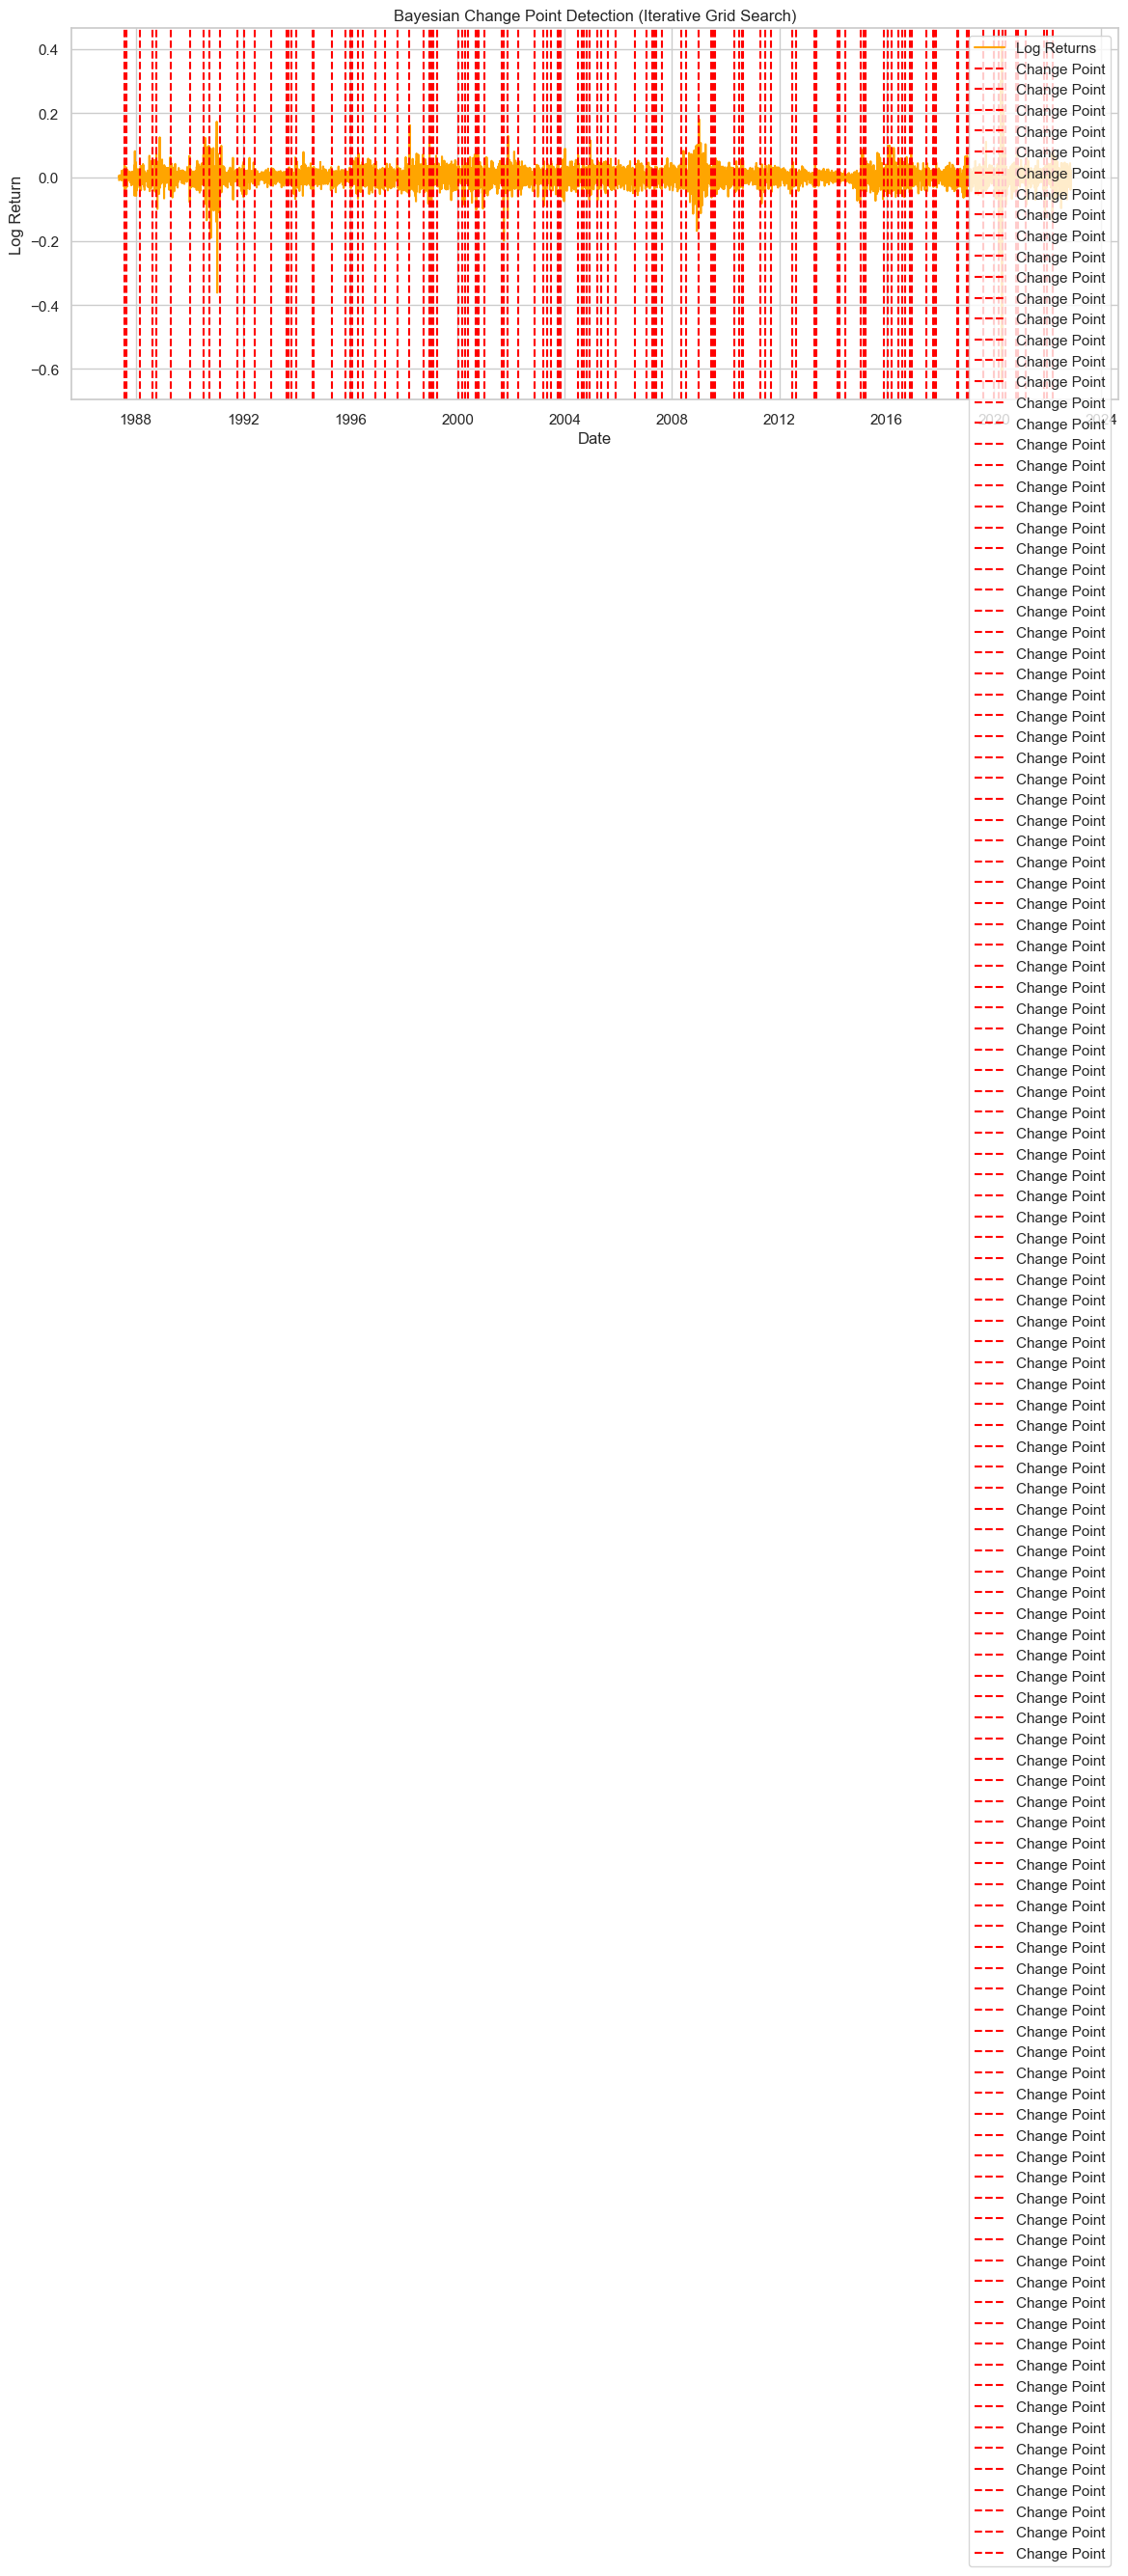

In [ ]:


# Define function to detect a single change point (fast grid search)
def detect_change_point(y, dates):
    """
    y: np.array of log returns
    dates: corresponding dates
    Returns: dict with change point date, mu1, mu2, std, segment indices
    """
    n = len(y)
    best_tau = None
    best_score = -np.inf
    best_mu1, best_mu2 = 0, 0
    
    # Ignore first and last 5% to avoid tiny segments
    min_idx = int(0.05 * n)
    max_idx = int(0.95 * n)
    
    for tau in range(min_idx, max_idx):
        mu1 = np.mean(y[:tau])
        mu2 = np.mean(y[tau:])
        sigma = np.std(y)
        # Log-likelihood assuming normal distribution
        ll = -0.5*np.sum((y[:tau]-mu1)**2/sigma**2) - 0.5*np.sum((y[tau:]-mu2)**2/sigma**2)
        if ll > best_score:
            best_score = ll
            best_tau = tau
            best_mu1, best_mu2 = mu1, mu2

    return {
        "index": best_tau,
        "date": dates[best_tau],
        "mu1": best_mu1,
        "mu2": best_mu2,
        "std": np.std(y)
    }

# Iterative multi-change-point detection
def detect_multiple_change_points(y, dates, min_segment=200, threshold=0.0001):
    events = []

    segments = [(0, len(y))]
    while segments:
        start, end = segments.pop(0)
        y_seg = y[start:end]
        dates_seg = dates[start:end]
        if len(y_seg) < min_segment:
            continue
        cp = detect_change_point(y_seg, dates_seg)
        # Only consider significant change
        if abs(cp["mu1"] - cp["mu2"]) > threshold:
            events.append(cp)
            # Split into before/after segments
            segments.append((start, start+cp["index"]))
            segments.append((start+cp["index"], end))
    # Sort events by date
    events = sorted(events, key=lambda x: x["date"])
    return events

# Prepare data
y = np.log(df["Price"]).diff().dropna().values
dates = df["Date"].iloc[1:].values  # align with diff

# Detect multiple change points
events = detect_multiple_change_points(y, dates)

# Display results
for e in events:
    print(f"Detected Change Point Date: {pd.Timestamp(e['date']).date()}, "
      f"Mean Before: {e['mu1']:.5f}, Mean After: {e['mu2']:.5f}, Std Dev: {e['std']:.5f}")

# Plot log returns with change points
plt.figure(figsize=(14,5))
plt.plot(dates, y, label='Log Returns', color='orange')
for e in events:
    plt.axvline(e['date'], color='red', linestyle='--', label='Change Point')
plt.title("Bayesian Change Point Detection (Iterative Grid Search)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()


In [ ]:
# 5️ Export multiple change points to CSV

# Prepare dataframe
detected_events_df = pd.DataFrame({
    "Date": [pd.Timestamp(e['date']).date() for e in events],  # convert numpy datetime64 to date
    "ChangePoint": [True]*len(events),
    "MeanBefore": [e['mu1'] for e in events],
    "MeanAfter": [e['mu2'] for e in events],
    "StdDev": [e['std'] for e in events]
})

# Save to CSV
output_file = project_root / "data" / "processed" / "detected_events.csv"
try:
    detected_events_df.to_csv(output_file, index=False)
    print(f"✅ Detected events saved to: {output_file}")
except Exception as e:
    print(f"❌ Failed to save CSV: {e}")

# Display results
for e in events:
    print(
        f"Detected Change Point Date: {pd.Timestamp(e['date']).date()}, "
        f"Mean Before: {e['mu1']:.5f}, Mean After: {e['mu2']:.5f}, Std Dev: {e['std']:.5f}"
    )

# Optional: display table in notebook
detected_events_df


✅ Detected events saved to: c:\Users\derej\Desktop\Kifya\changepoint_analysis\data\processed\detected_events.csv
Detected Change Point Date: 1987-08-04, Mean Before: 0.00226, Mean After: -0.00123, Std Dev: 0.01765
Detected Change Point Date: 1987-08-25, Mean Before: -0.01207, Mean After: -0.00059, Std Dev: 0.01865
Detected Change Point Date: 1988-03-03, Mean Before: -0.00178, Mean After: 0.00071, Std Dev: 0.01878
Detected Change Point Date: 1988-08-23, Mean Before: -0.00067, Mean After: -0.00919, Std Dev: 0.01824
Detected Change Point Date: 1988-10-06, Mean Before: -0.00144, Mean After: 0.00227, Std Dev: 0.01969
Detected Change Point Date: 1989-04-21, Mean Before: 0.00501, Mean After: 0.00021, Std Dev: 0.02100
Detected Change Point Date: 1990-01-08, Mean Before: 0.00032, Mean After: -0.00339, Std Dev: 0.01976
Detected Change Point Date: 1990-07-10, Mean Before: -0.00027, Mean After: 0.01755, Std Dev: 0.02227
Detected Change Point Date: 1990-09-28, Mean Before: 0.00093, Mean After: -0.0

,Date,ChangePoint,MeanBefore,MeanAfter,StdDev
0,1987-08-04,True,0.002257,-0.001235,0.017652
1,1987-08-25,True,-0.012072,-0.000595,0.018653
2,1988-03-03,True,-0.001777,0.000706,0.018780
3,1988-08-23,True,-0.000669,-0.009192,0.018242
4,1988-10-06,True,-0.001442,0.002273,0.019686
...,...,...,...,...,...
115,2020-11-26,True,0.014659,0.002399,0.019719
116,2021-03-08,True,0.005590,0.001100,0.019074
117,2021-11-10,True,0.002084,-0.006249,0.021947
118,2021-12-21,True,0.001468,0.011777,0.022481


In [3]:
# Quantitative metrics for change point detection

import pandas as pd

# Load detected events
df = pd.read_csv("../data/processed/detected_events.csv")

# Compute change magnitude
df["ChangeMagnitude"] = df["MeanAfter"] - df["MeanBefore"]

# Metrics
num_points = len(df)
avg_magnitude = df["ChangeMagnitude"].mean()
max_volatility = df["StdDev"].max()

print(f"Number of detected change points: {num_points}")
print(f"Average magnitude of change points: ${avg_magnitude:.2f} per barrel")
print(f"Largest single-day volatility: ${max_volatility:.2f} per barrel")

# Optional: export to CSV for report table
df.to_csv("../data/processed/change_point_metrics.csv", index=False)


Number of detected change points: 120
Average magnitude of change points: $-0.00 per barrel
Largest single-day volatility: $0.05 per barrel
